In [81]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers as L, models as M, initializers as I, callbacks as CB, backend as K, optimizers as O, constraints as CN, regularizers as R

import RBF_Dense

##### Prepare Dataset

In [66]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [67]:
from sklearn.preprocessing import OneHotEncoder

y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray()

y_test = ohe.transform(y_test).toarray()

In [68]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

###### Remember in case without gamma the minimum values means most likelyhood class

In [69]:
def acc(ytr, ypr):
    true_class = K.argmax(ytr, axis=-1)
    pred_class = K.argmin(ypr, axis=-1)
    return K.mean(K.equal(true_class, pred_class))

##### Construct and train net with Metric Loss

In [70]:
K.clear_session()

m = M.Sequential()
m.add(L.InputLayer(input_shape=(28, 28, 1), ))
m.add(L.Conv2D(6, kernel_size=(5,5)))
m.add(L.MaxPool2D())
m.add(L.Activation("relu"))
m.add(L.Conv2D(16, kernel_size=(5,5)))
m.add(L.MaxPool2D())
m.add(L.Activation("relu"))
m.add(L.Flatten())
m.add(L.Dense(120))
m.add(L.Activation("relu"))
m.add(L.Dense(84))
m.add(L.Activation("relu"))
m.add(RBF_Dense.RBFDense(10, 2, norm_type="l2", use_gamma=False))


m.compile(O.Adam(3e-4), loss=RBF_Dense.SoftML_loss(1), metrics=[acc])

h = m.fit(x_train, y_train, epochs=50, batch_size=512, validation_data=(x_test, y_test))

/spark/git_prjts/not_git/rbf/RBF_Dense.py:21: UserWarning: do not use smothed labels for SoftML_loss, only ones and zeros are available
  warnings.warn("do not use smothed labels for SoftML_loss, only ones and zeros are available")


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 17s 282us/step - loss: 6.5664 - acc: 0.2648 - val_loss: 3.4721 - val_acc: 0.3878
Epoch 2/50
60000/60000 [==============================] - 15s 249us/step - loss: 2.8870 - acc: 0.5304 - val_loss: 2.3420 - val_acc: 0.6624
Epoch 3/50
60000/60000 [==============================] - 14s 227us/step - loss: 2.0572 - acc: 0.7405 - val_loss: 1.7788 - val_acc: 0.8058
Epoch 4/50
60000/60000 [==============================] - 12s 194us/step - loss: 1.6238 - acc: 0.8392 - val_loss: 1.4647 - val_acc: 0.8654
Epoch 5/50
60000/60000 [==============================] - 21s 358us/step - loss: 1.3582 - acc: 0.8833 - val_loss: 1.2531 - val_acc: 0.8944
Epoch 6/50
60000/60000 [==============================] - 21s 347us/step - loss: 1.1634 - acc: 0.9079 - val_loss: 1.0750 - val_acc: 0.9172
Epoch 7/50
60000/60000 [==============================] - 18s 299us/step - loss: 1.0061 - acc: 0.9240 - val_loss: 0.

##### Coeficient l=1 of Ml_loss means what we are limited the area of positive answer by 1. So we can obtain samples to witch we cannot determine class:

In [71]:
pred = m.predict(x_test)

unknown = x_test[np.all(pred > 1., axis=1)]

unknown.shape

(71, 28, 28, 1)

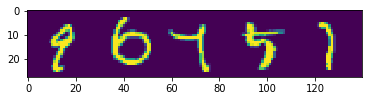

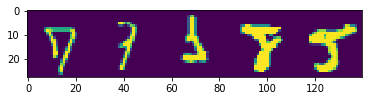

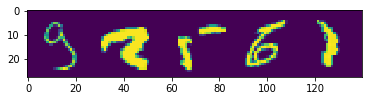

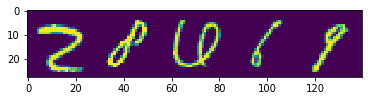

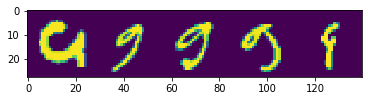

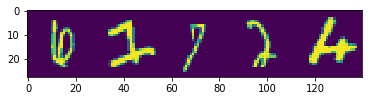

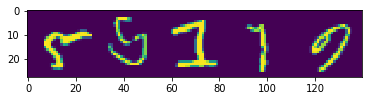

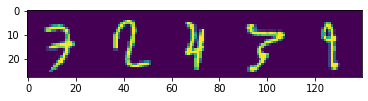

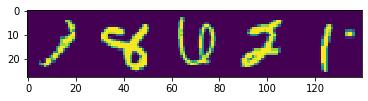

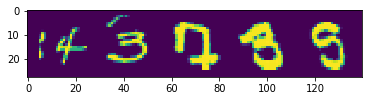

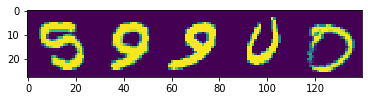

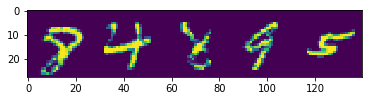

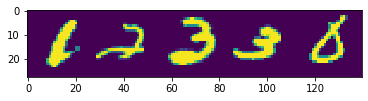

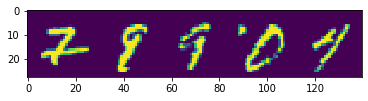

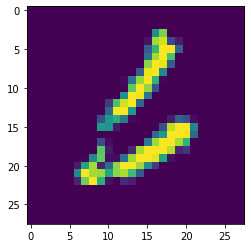

In [72]:
for i in range(0, len(unknown), 5):
    plt.imshow(np.hstack(unknown[i:i+5])[..., 0])
    plt.show()

##### Construct and train net with Cross Entropy

In [96]:
K.clear_session()

m = M.Sequential()
m.add(L.InputLayer(input_shape=(28, 28, 1), ))
m.add(L.Conv2D(6, kernel_size=(5,5)))
m.add(L.MaxPool2D())
m.add(L.Activation("relu"))
m.add(L.Conv2D(16, kernel_size=(5,5)))
m.add(L.MaxPool2D())
m.add(L.Activation("relu"))
m.add(L.Flatten())
m.add(L.Dense(120))
m.add(L.Activation("relu"))
m.add(L.Dense(84))
m.add(L.Activation("relu"))
m.add(RBF_Dense.RBFDense(10, 2, norm_type="l2", use_gamma=False))
m.add(RBF_Dense.SoftMin(rejection_class=True, lambd=1.))

#add extra rejection class
y_train_ = np.concatenate([y_train, np.zeros([y_train.shape[0], 1])], axis=-1)
y_test_ = np.concatenate([y_test, np.zeros([y_test.shape[0], 1])], axis=-1)

m.compile(optimizer=O.Adam(3e-4),
          loss="categorical_crossentropy",
          metrics=["acc"])

h = m.fit(x_train, y_train_, epochs=50, batch_size=512, validation_data=(x_test, y_test_))

[None, 11]
(?, 11)
(60000, 11)
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 17s 279us/step - loss: 3.9013 - acc: 0.1143 - val_loss: 1.9842 - val_acc: 0.2279
Epoch 2/50
60000/60000 [==============================] - 14s 232us/step - loss: 1.6718 - acc: 0.3115 - val_loss: 1.3866 - val_acc: 0.4070
Epoch 3/50
60000/60000 [==============================] - 13s 219us/step - loss: 1.2557 - acc: 0.4636 - val_loss: 1.1062 - val_acc: 0.5386
Epoch 4/50
60000/60000 [==============================] - 16s 271us/step - loss: 1.0298 - acc: 0.5847 - val_loss: 0.9358 - val_acc: 0.6490
Epoch 5/50
60000/60000 [==============================] - 13s 223us/step - loss: 0.8901 - acc: 0.6790 - val_loss: 0.8285 - val_acc: 0.7219
Epoch 6/50
60000/60000 [==============================] - 16s 270us/step - loss: 0.7944 - acc: 0.7536 - val_loss: 0.7488 - val_acc: 0.7894
Epoch 7/50
60000/60000 [==============================] - 18s 304us/step - loss: 0.72

In [97]:
pred = m.predict(x_test)

unknown = x_test[np.argmax(pred, axis=-1) == 10]

unknown.shape

(66, 28, 28, 1)

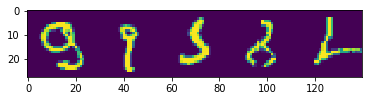

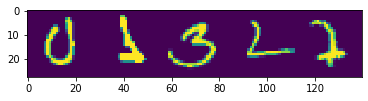

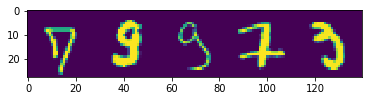

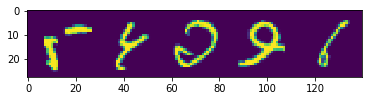

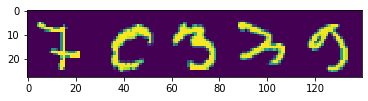

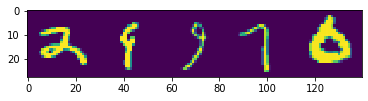

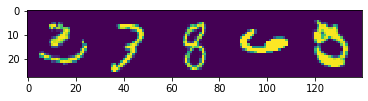

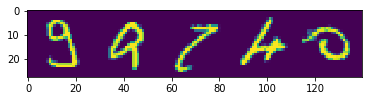

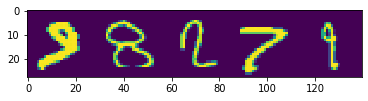

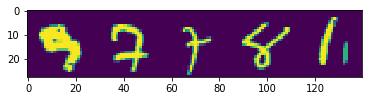

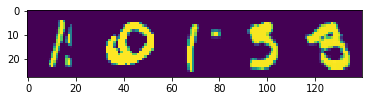

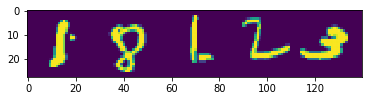

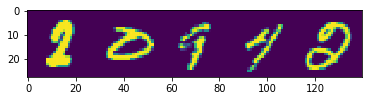

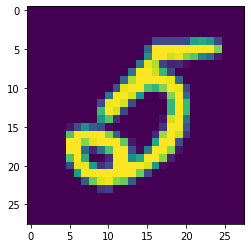

In [98]:
for i in range(0, len(unknown), 5):
    plt.imshow(np.hstack(unknown[i:i+5])[..., 0])
    plt.show()